
<a id='general-packages'></a>
How to read this lecture…

- If using QuantEcon lectures for the first time on a computer, execute ] add InstantiateFromURL inside of a notebook or the REPL  
- For some notebooks, enable content with “Trust” on the command tab of Jupyter lab  
- Code should execute sequentially if run in a Jupyter notebook  
- Please direct feedback to [contact@quantecon.org](mailto:contact@quantecon.org") or [discourse forum](http://discourse.quantecon.org/)  

# General Purpose Packages

## Contents

- [General Purpose Packages](#General-Purpose-Packages)  
  - [Overview](#Overview)  
  - [Numerical Integration](#Numerical-Integration)  
  - [Interpolation](#Interpolation)  
  - [Linear Algebra](#Linear-Algebra)  
  - [General Tools](#General-Tools)  

## Overview

The size of the ecosystem depends on what kind of package you are thinking of. While Julia lacks the massive scientific ecosystem of Python, it has successfully attracted a small army of enthusiastic and talented developersJulia has both a large number of useful, well written libraries and many incomplete poorly maintained proofs-of-concept

A major advantage of Julia libraries is that, because Julia itself is sufficiently fast, there is less need to mix in low level languages like C and Fortran

As a result, most Julia libraries are written exclusively in Julia

Not only does this make the libraries more portable, it makes them much easier to dive into, read, learn from and modify

In this lecture we introduce a few of the Julia libraries that we’ve found particularly useful for quantitative work in economics

Also see [data and statistical packages](data_statistical_packages.ipynb#) and [optimization, solver, and related packages](optimization_solver_packages.ipynb#) for more domain specific packages

### Setup

In [1]:
using InstantiateFromURL
activate_github("QuantEcon/QuantEconLectureAllPackages", tag = "v0.9.0") # activate the QuantEcon environment

using LinearAlgebra, Statistics, Compat # load common packages

We have seen more detail on this package than this, so probably best to rewrite 
 Distributions Functions for manipulating probability distributions and generating randomvariables are supplied by the excellent `Distributions.jl <https://github.com/JuliaStats/Distributions.jl>`_ packageWe'll restrict ourselves to a few simple examples (the package itself has `detailed documentation <https://juliastats.github.io/Distributions.jl/latest/index.html>`_)* ``d = Normal(m, s)`` creates a normal distribution with mean :math:`m` and standard deviation :math:`s`* defaults are ``m = 0`` and ``s = 1``* ``d = Uniform(a, b)`` creates a uniform distribution on interval :math:`[a, b]`* defaults are ``a = 0`` and ``b = 1``* ``d = Binomial(n, p)`` creates a binomial over :math:`n` trials with success probability :math:`p`* defaults are ``n = 1`` and ``p = 0.5``Distributions.jl defines various methods for acting on these instances in order to obtain* random draws* evaluations of pdfs (densities), cdfs (distribution functions), quantiles, etc.* mean, variance, kurtosis, etc.For example,* To generate ``k`` draws from the instance ``d`` use ``rand(d, k)``* To obtain the mean of the distribution use ``mean(d)``* To evaluate the probability density function of ``d`` at ``x`` use ``pdf(d, x)``Further details on the interface can be found `here <https://juliastats.github.io/Distributions.jl/latest/univariate.html#Common-Interface-1>`__Several multivariate distributions are also implemented

## Numerical Integration

Many applications require directly calculating a numerical derivative and calculating expectations

### Adaptive Quadrature

A high accuracy solution for calculating numerical integrals is [QuadGK](https://github.com/JuliaMath/QuadGK.jl)

In [2]:
using QuadGK
@show value, tol = quadgk(cos, -2π, 2π);

(value, tol) = quadgk(cos, -2π, 2π) = (-1.5474478810961125e-14, 5.7846097329025695e-24)


This is an adaptive Gauss-Kronrod integration technique that’s relatively accurate for smooth functions

However, its adaptive implementation makes it slow and not well suited to inner loops

### Gaussian Quadrature

Alternatively, many integrals can be done efficiently with (non-adaptive) [Gaussian quadrature](https://en.wikipedia.org/wiki/Gaussian_quadrature)

For example, using [FastGaussQuadrature.jl](https://github.com/ajt60gaibb/FastGaussQuadrature.jl)

In [3]:
using FastGaussQuadrature
x, w = gausslegendre( 100_000 ); # i.e. find 100,000 nodes

# integrates f(x) = x^2 from -1 to 1
f(x) = x^2
@show w ⋅ f.(x); # calculate integral

w ⋅ f.(x) = 0.6666666666666665


The only problem with the FastGaussQuadrature package is that you will need to deal with affine transformations to the non-default domains yourself

Alternatively, QuantEcon.jl has routines for Gaussian quadrature that translate the domains

In [4]:
using QuantEcon

x, w = qnwlege(65, -2π, 2π);
@show w ⋅ cos.(x); # i.e. on [-2π, 2π] domain

┌ Info: Recompiling stale cache file /Users/arnavsood/.julia/compiled/v1.0/QuantEcon/V0Mv9.ji for QuantEcon [fcd29c91-0bd7-5a09-975d-7ac3f643a60c]
└ @ Base loading.jl:1184


w ⋅ cos.(x) = -3.0062757838678067e-15


### Expectations

If the calculations of the numerical integral is simply for calculating mathematical expectations of a particular distribution, then [Expectations.jl](https://github.com/QuantEcon/Expectations.jl) provides a convenient interface

Under the hood, it is finding the appropriate Gaussian quadrature scheme for the distribution and using FastGaussQuadrature

In [5]:
using Distributions, Expectations
dist = Normal()
E = expectation(dist)
f(x) = x
@show E(f) #i.e. identity

# Or using as a linear operator
f(x) = x^2
x = nodes(E)
w = weights(E)
E * f.(x) == f.(x) ⋅ w

E(f) = 2.889272167366858e-17


true

## Interpolation

In economics we often wish to interpolate discrete data (i.e., build continuous functions that join discrete sequences of .. points)

The package we usually turn to for this purpose is [Interpolations.jl](https://github.com/JuliaMath/Interpolations.jl)

There are a variety of options, but we will only demonstrate the convenience notation

### Univariate with a Regular Grid

Let’s start with the univariate case

We begin by creating some data points, using a sine function

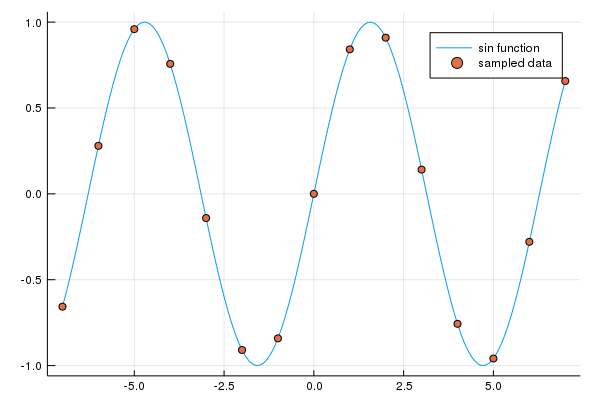

In [6]:
using Interpolations
using Plots
gr(fmt=:png)

x = -7:7 # x points, coase grid
y = sin.(x) # corresponding y points

xf = -7:0.1:7        # fine grid
plot(xf, sin.(xf), label = "sin function")
scatter!(x, y, label = "sampled data", markersize = 4)

To implement linear and cubic spline interpolation

li(0.3) = 0.25244129544236954


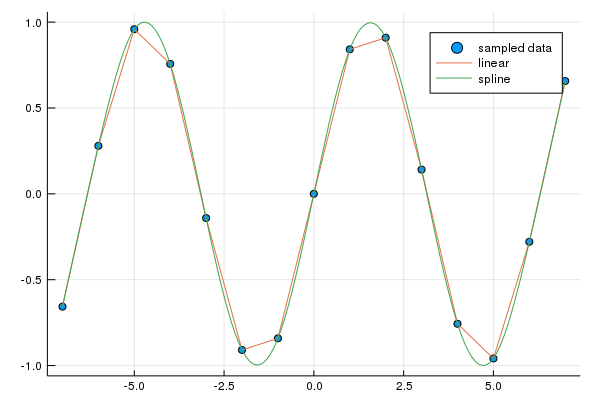

In [7]:
li = LinearInterpolation(x, y)
li_spline = CubicSplineInterpolation(x, y)

@show li(0.3) # evaluate at a single point

scatter(x, y, label = "sampled data", markersize = 4)
plot!(xf, li.(xf), label = "linear")
plot!(xf, li_spline.(xf), label = "spline")

### Univariate with Irregular Grid

In the above, the LinearInterpolation function uses a specialized function for regular grids since the x is a Range type

For an arbitrary, irregular grid

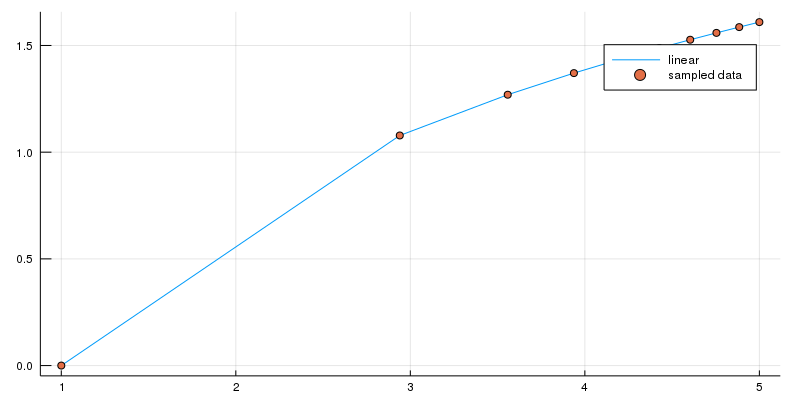

In [8]:
x = log.(range(1, exp(4), length = 10)) .+ 1  # uneven grid
y = log.(x) # corresponding y points

interp = LinearInterpolation(x, y)

xf = log.(range(1,  exp(4), length = 100)) .+ 1 # finer grid

plot(xf, interp.(xf), label = "linear")
scatter!(x, y, label = "sampled data", markersize = 4, size = (800, 400))

At this point, Interpolations.jl does not have support for cubic splines with irregular grids, but there are plenty of other packages that do (e.g. [Dierckx.jl](https://github.com/kbarbary/Dierckx.jl)  and [GridInterpolations.jl](https://github.com/sisl/GridInterpolations.jl))

### Multivariate Interpolation

Interpolating a regular multivariate function uses the same function

In [9]:
f(x,y) = log(x+y)
xs = 1:0.2:5
ys = 2:0.1:5
A = [f(x,y) for x in xs, y in ys]

# linear interpolation
interp_linear = LinearInterpolation((xs, ys), A)
@show interp_linear(3, 2) # exactly log(3 + 2)
@show interp_linear(3.1, 2.1) # approximately log(3.1 + 2.1)

# cubic spline interpolation
interp_cubic = CubicSplineInterpolation((xs, ys), A)
@show interp_cubic(3, 2) # exactly log(3 + 2)
@show interp_cubic(3.1, 2.1) # approximately log(3.1 + 2.1);

interp_linear(3, 2) = 1.6094379124341003
interp_linear(3.1, 2.1) = 1.6484736801441782
interp_cubic(3, 2) = 1.6094379124341
interp_cubic(3.1, 2.1) = 1.6486586594237707


See [Interpolations.jl documentation](https://github.com/JuliaMath/Interpolations.jl#convenience-notation) for more details on options and settings

-----------------------------We can also interpolate in higher dimensionsThe following example gives one illustration.. code-block:: julialetn = 5x = range(-3,  3, length = n)y = copy(x)z = zeros(n, n)f(x, y) = cos(x^2 + y^2) / (1 + x^2 + y^2)for i ∈ 1:nfor j ∈ 1:nz[j, i] = f(x[i], y[j])endenditp = interpolate((x, y), z, Gridded(Linear()));nf = 50xf = range(-3,  3, length = nf)yf = copy(xf)zf = zeros(nf, nf)ztrue = similar(zf)for i ∈ 1:nffor j ∈ 1:nfzf[j, i] = itp[xf[i], yf[j]]ztrue[j, i] = f(xf[i], yf[j])endendgrid = gridmake(x, y)z = reshape(z, n * n, 1)surface(xf, yf, zf', color = :greens, falpha = 0.7, cbar = false)surface!(xf, yf, ztrue', fcolor = :blues, falpha = 0.25, cbar = false)scatter!(grid[:, 1], grid[:, 2], vec(z), legend = :none, color = :black,markersize = 4)endThe original function is in blue, while the linear interpolant is shown in greenOther Topics=================More numerical integration (and differentiation) routines can be found in thepackage `Calculus <https://github.com/JuliaMath/Calculus.jl>`_

## Linear Algebra

### Standard Library

The standard library contains many useful routines for linear algebra, in
addition to standard functions such as det(), inv(), factorize(), etc.

Routines are available for

- Cholesky factorization  
- LU decomposition  
- Singular value decomposition,  
- Schur factorization, etc.  


See [here](https://docs.julialang.org/en/stable/manual/linear-algebra/) for further details

## General Tools

### LaTeXStrings.jl

When you need to properly escape latex code (e.g. for equation labels), use [LaTeXStrings.jl](https://github.com/stevengj/LaTeXStrings.jl)

In [10]:
using LaTeXStrings
L"an equation: $1 + \alpha^2$"

L"an equation: $1 + \alpha^2$"

### ProgressMeter.jl

For long-running operations, you can use the [ProgressMeter.jl](https://github.com/timholy/ProgressMeter.jl) package

To use the package, you simply put a macro in front of for loops, etc.

From the documentation

In [11]:
using ProgressMeter

@showprogress 1 "Computing..." for i in 1:50
    sleep(0.1) # some computation....
end

Computing...100%|███████████████████████████████████████| Time: 0:00:06
